In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns  
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import  SVC

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.base import clone

from sklearn.metrics import classification_report,confusion_matrix,RocCurveDisplay,ConfusionMatrixDisplay
sns.set()


In [2]:
df= pd.read_csv('Heart deises cleand.csv')

In [3]:
df.head()

,age,Gender,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,class
0,4,1,0,3,145.0,233.0,1,0,150.0,0,2.3,0
1,4,1,0,0,160.0,286.0,0,0,108.0,1,1.5,1
2,4,1,0,0,120.0,229.0,0,0,129.0,1,2.6,1
3,1,1,0,2,130.0,250.0,0,1,187.0,0,3.5,0
4,2,0,0,1,130.0,204.0,0,0,172.0,0,1.4,0


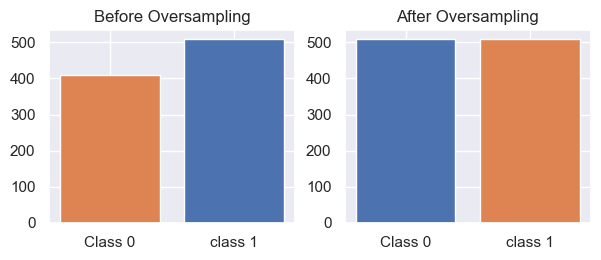

In [4]:
fig, axs = plt.subplots(1,2 ,figsize=(7,2.5),sharex=True,)
default_palette = list(sns.color_palette())

axs[0].bar(x=df['class'].value_counts().index ,height= df['class'].value_counts().values ,color =default_palette)
axs[0].set_title('Before Oversampling')

oversample= SMOTE(sampling_strategy='minority')
df, y_over = oversample.fit_resample(df.iloc[:, :-1],df['class'])
df['class'] =y_over


axs[1].bar(x=df['class'].value_counts().index ,height= df['class'].value_counts().values ,color =default_palette)
axs[1].set_title('After Oversampling')


axs[0].set_xticks([0 ,1])
axs[0].set_xticklabels(['Class 0' ,'class 1'])

plt.show()


In [5]:


sc = StandardScaler()
X_train = sc.fit_transform(df.iloc[:,:-1])

df =pd.DataFrame(X_train,columns=df.columns[:-1])
df['class'] =y_over

In [6]:
df

,age,Gender,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,class
0,1.178041,0.577350,-1.054726,2.351116,0.794764,0.282265,2.522364,-1.549378,0.450446,-0.755198,1.456941,0
1,1.178041,0.577350,-1.054726,-0.848081,1.693721,0.872896,-0.396454,-1.549378,-1.228086,1.324155,0.659419,1
2,1.178041,0.577350,-1.054726,-0.848081,-0.703499,0.237690,-0.396454,-1.549378,-0.388820,1.324155,1.756013,1
3,-1.864899,0.577350,-1.054726,1.284717,-0.104194,0.471713,-0.396454,0.050386,1.929153,-0.755198,2.653226,0
4,-0.850586,-1.732051,-1.054726,0.218318,-0.104194,-0.040910,-0.396454,-1.549378,1.329677,-0.755198,0.559728,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1011,-0.850586,-1.732051,-0.157988,0.218318,-0.104194,0.496715,-0.396454,0.050386,0.631376,-0.755198,-0.835937,0
1012,-0.850586,0.577350,-1.054726,-0.848081,0.009739,-0.003620,-0.396454,-1.549378,1.169817,-0.755198,-0.737332,0
1013,0.163728,0.577350,0.738750,-0.848081,0.252834,-0.274286,-0.396454,0.050386,-0.008703,-0.755198,-0.582546,0
1014,-0.850586,-1.732051,-1.054726,0.218318,-0.226933,1.117528,-0.396454,-1.549378,1.243029,-0.755198,-0.835937,0


In [7]:

def train_best_model(X_over, k):
    data = X_over.index
    best_model = None
    best_score = 0
    best_train_data = None
    best_test_data = None
    df = pd.DataFrame(columns=["fold_" + str(n) for n in range(1, k + 1)])

    models = {
        'SVC': SVC(),
        'RandomForest': RandomForestClassifier(),
        'KNN': KNeighborsClassifier(),
        'LogisticRegression': LogisticRegression()
    }

    kfold = KFold(n_splits=k, shuffle=True, random_state=1)

    for model_name, model in models.items():
        scores = []
        train_data = []
        test_data = []
        
        for fold_n, (train, test) in enumerate(kfold.split(data), start=1):
            x_train = X_over.loc[data[train]]
            y_train = X_over.loc[data[test]]
            
            # Check if any class is present in both train and test
            if len(set(train) & set(test)) != 0:
                continue
            model = clone(model)

            model.fit(x_train.iloc[:, :-1], x_train['class'])
            y_pred = model.predict(y_train.iloc[:, :-1])
            
            score = accuracy_score(y_train['class'], y_pred)
            
        
            scores.append(score)
            df.loc[model_name, "fold_" + str(fold_n)] = score

            if score > best_score:
                best_score = max(scores)
                best_model = model_name
                best_train_data = x_train
                best_test_data = y_train
                yourmodel= model
    df["Max"] =[ df.loc[i].max() for i in df.index]
    
    return best_model, best_score, best_train_data, best_test_data, df,yourmodel


In [8]:
best_model, best_score, best_train_data, best_test_data,Folde_State,yourmodel =train_best_model(df,8)

In [9]:
k=8
test_size =(df.shape[0] /k)
train_size = df.shape[0] -test_size
print("Training Sample :", round(train_size / df.shape[0] *100,2))
print("Testing Sample :", round(test_size / df.shape[0] *100,2))

Training Sample : 87.5
Testing Sample : 12.5


In [10]:
Folde_State

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,Max
SVC,0.811024,0.818898,0.771654,0.76378,0.826772,0.866142,0.905512,0.84252,0.905512
RandomForest,0.858268,0.80315,0.771654,0.80315,0.818898,0.874016,0.88189,0.858268,0.881890
KNN,0.811024,0.811024,0.755906,0.811024,0.850394,0.850394,0.889764,0.826772,0.889764
LogisticRegression,0.80315,0.811024,0.80315,0.787402,0.84252,0.858268,0.850394,0.826772,0.858268


In [11]:
print('best_model',best_model)
print('best_score',best_score)

best_model SVC
best_score 0.905511811023622


In [12]:
conf =ConfusionMatrixDisplay(confusion_matrix(y_true=best_test_data['class'] ,  y_pred= yourmodel.predict(best_test_data.iloc[:,:-1] ) ))

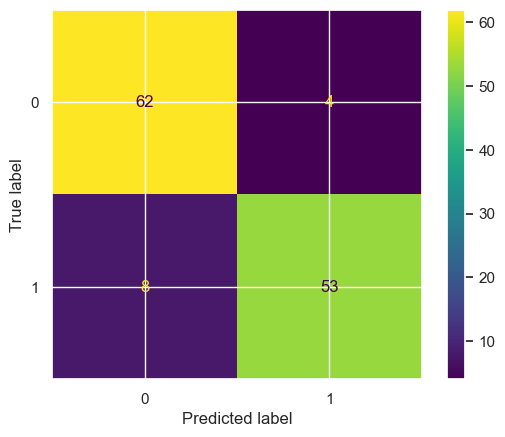

In [13]:

conf.from_estimator(yourmodel ,best_test_data.iloc[:,:-1], best_test_data.iloc[:,-1] )

In [14]:
print(classification_report(y_true=best_test_data['class'] ,  y_pred= yourmodel.predict(best_test_data.iloc[:,:-1] ) ))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91        66
           1       0.93      0.87      0.90        61

    accuracy                           0.91       127
   macro avg       0.91      0.90      0.91       127
weighted avg       0.91      0.91      0.91       127



(0.0, 1.05)

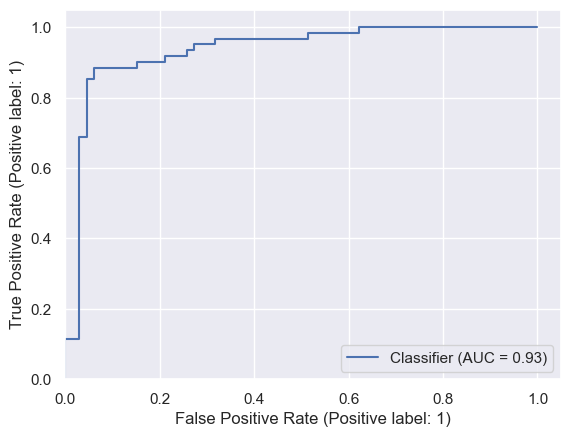

In [15]:

y_pred = yourmodel.predict(best_test_data.iloc[:,:-1] )
y_scores = yourmodel.decision_function(best_test_data.iloc[:,:-1] )  
roc_display = RocCurveDisplay.from_predictions(best_test_data.iloc[:,-1], y_scores)


plt.xlim(0)
plt.ylim(0)


In [21]:
yourmodel.

<bound method BaseSVC.decision_function of SVC()>